### Import libraries

In [239]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.10.0


### Set seed for reproducibility

In [240]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

 # Load the training dataset

In [241]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy')
y = np.load(path+r'\training\y_train.npy')
print(X.shape)   #Note as sequences are already built, with window 36
print(y.shape)
print(X.dtype)
print(y.dtype)

(2429, 36, 6)
(2429,)
float64
int32


In [242]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

Plotting the classes distributions

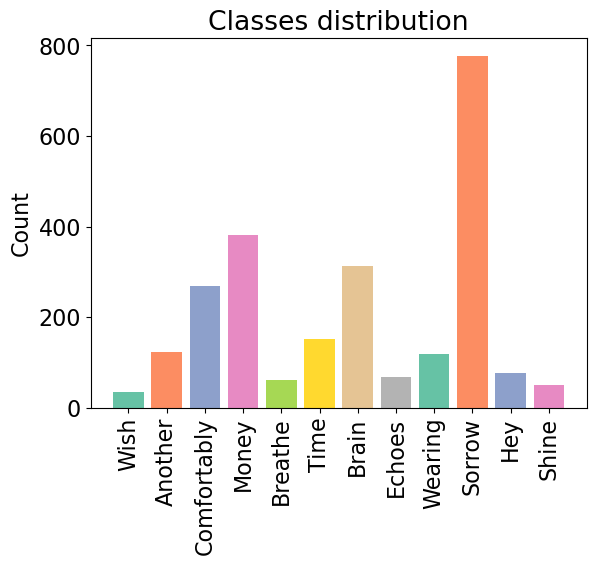

In [243]:
#vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


 Train-test split

In [244]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print("training set : ", X_train.shape)
print("test set: ", X_test.shape)

training set :  (1943, 36, 6)
test set:  (486, 36, 6)


Application of Min Max Scaler to the dataset

In [245]:
features_num = X_train.shape[2]
print("features: ", features_num)

scalers = {}
for i in range(features_num):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(features_num):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

features:  6


Categorical labels for the training and test data

In [246]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(1943, 12)
(486, 12)


## Build the models

In [247]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200


#### Vanilla Long Short Term Memory (LSTM) Neural Network

In [248]:
def build_LSTM_classifier(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # in the LSTM layers: 
    # return_sequences=True -> output = batch_size * timestamps * features
    # return_sequences=False -> output = batch_size * 1 (just last timestamp) * features

    # Feature extractor
    lstm = tfkl.LSTM(512, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(512, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(256, return_sequences=False)(lstm)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)

    # Classifier
    dense = tfkl.Dense(256, activation='relu')(dropout)
    dense = tfkl.Dense(256, activation='relu')(dense)
    dense = tfkl.Dense(128, activation='relu')(dense)
    dropout = tfkl.Dropout(.4, seed=seed)(dense)
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-4), metrics='accuracy')

    # Return the model
    return model

In [249]:
model = build_LSTM_classifier(input_shape)
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_45 (LSTM)              (None, 36, 512)           1062912   
                                                                 
 lstm_46 (LSTM)              (None, 36, 512)           2099200   
                                                                 
 lstm_47 (LSTM)              (None, 256)               787456    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 256)               65792     
                                                                 
 dense_59 (Dense)            (None, 256)               65792

In [250]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 9s 234ms/step - loss: 2.2715 - accuracy: 0.3221 - val_loss: 1.9703 - val_accuracy: 0.4051 - lr: 3.0000e-04
Epoch 2/200
14/14 [==============================] - 2s 126ms/step - loss: 1.8538 - accuracy: 0.4165 - val_loss: 1.6312 - val_accuracy: 0.4103 - lr: 3.0000e-04
Epoch 3/200
14/14 [==============================] - 2s 130ms/step - loss: 1.5965 - accuracy: 0.4743 - val_loss: 1.3838 - val_accuracy: 0.5385 - lr: 3.0000e-04
Epoch 4/200
14/14 [==============================] - 2s 125ms/step - loss: 1.4171 - accuracy: 0.5400 - val_loss: 1.3701 - val_accuracy: 0.5590 - lr: 3.0000e-04
Epoch 5/200
14/14 [==============================] - 2s 124ms/step - loss: 1.2793 - accuracy: 0.5904 - val_loss: 1.2140 - val_accuracy: 0.6000 - lr: 3.0000e-04
Epoch 6/200
14/14 [==============================] - 2s 125ms/step - loss: 1.1858 - accuracy: 0.6127 - val_loss: 1.2769 - val_accuracy: 0.6051 - lr: 3.0000e-04
Epoch 7/200
14/14 [=====================

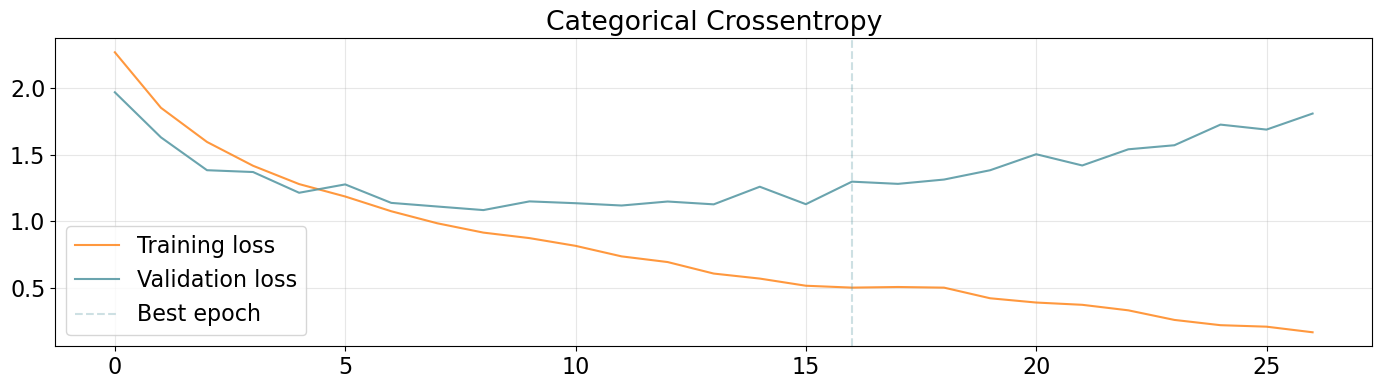

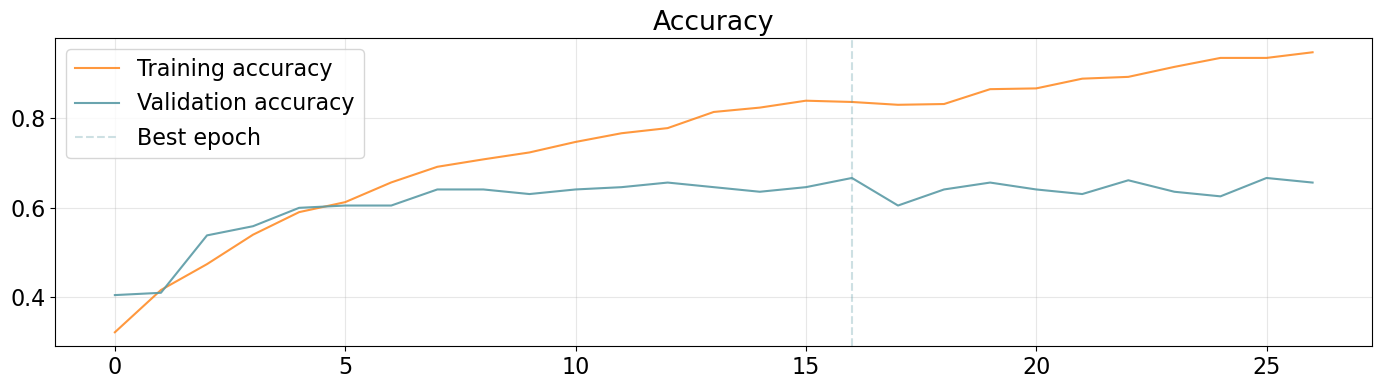

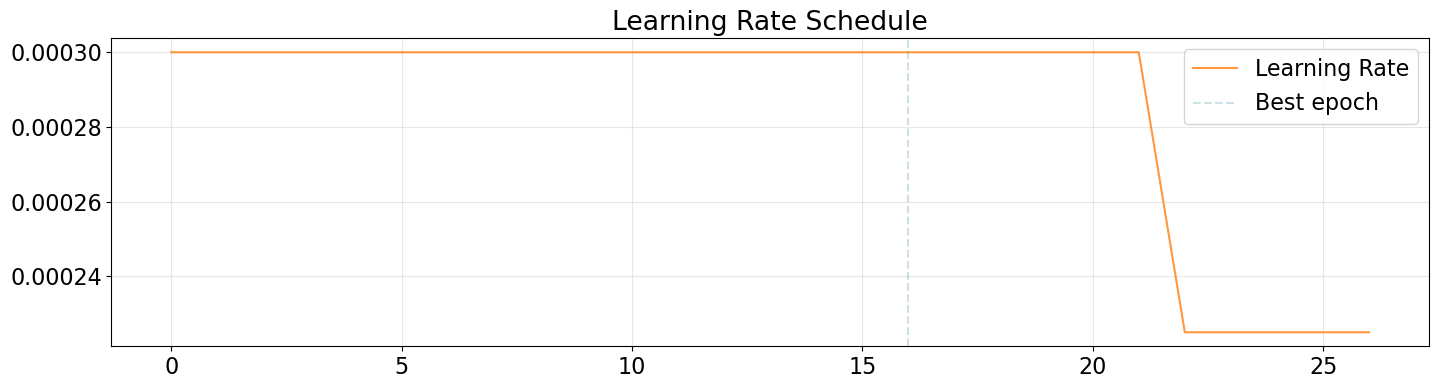

In [251]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.title('Learning Rate Schedule')
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

LSTM model evaluation

In [252]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 2s 23ms/step


(486, 12)

Accuracy: 0.6296
Precision: 0.553
Recall: 0.4893
F1: 0.5055


d:\Programs\Anaconda\envs\anndl\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


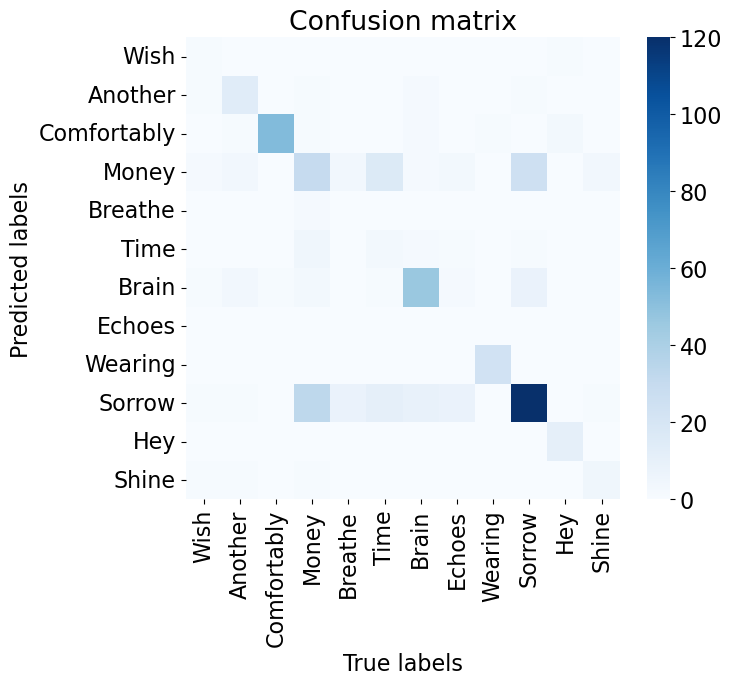

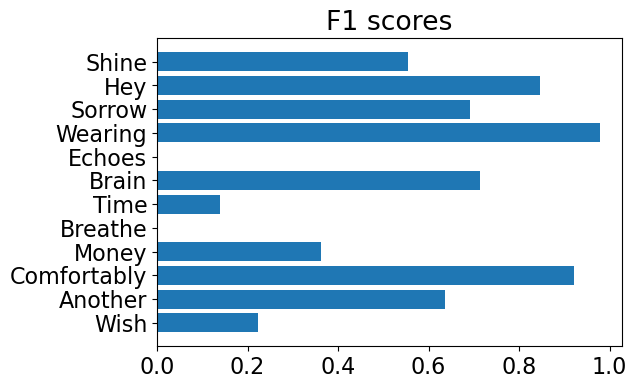

In [253]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix')
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# horizontal bar plot of the f1 scores for each class
plt.figure(figsize=(6,4))
plt.barh(y=list(label_mapping.keys()), width=f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None))
plt.title('F1 scores')
plt.show()

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [254]:
def build_BiLSTM_classifier(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(512, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(384, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=False))(bilstm)
    dropout = tfkl.Dropout(.4, seed=seed)(bilstm)

    # Classifier
    dense = tfkl.Dense(256, activation='relu')(dropout)
    dense = tfkl.Dense(128, activation='relu')(dense)
    output_layer = tfkl.Dense(classes, activation='softmax')(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model2')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-4), metrics='accuracy')

    # Return the model
    return model

In [255]:
model = build_BiLSTM_classifier(input_shape)
model.summary() #note double number of parameters (this is because we have a bidirectional lstm)

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_17 (Bidirecti  (None, 36, 1024)         2125824   
 onal)                                                           
                                                                 
 bidirectional_18 (Bidirecti  (None, 36, 768)          4328448   
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 512)              2099200   
 onal)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                            

In [256]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 16s 474ms/step - loss: 1.9973 - accuracy: 0.3741 - val_loss: 1.5523 - val_accuracy: 0.4564 - lr: 3.0000e-04
Epoch 2/200
14/14 [==============================] - 4s 258ms/step - loss: 1.4903 - accuracy: 0.4857 - val_loss: 1.2783 - val_accuracy: 0.5641 - lr: 3.0000e-04
Epoch 3/200
14/14 [==============================] - 4s 261ms/step - loss: 1.2158 - accuracy: 0.5898 - val_loss: 1.1386 - val_accuracy: 0.5795 - lr: 3.0000e-04
Epoch 4/200
14/14 [==============================] - 4s 268ms/step - loss: 1.0320 - accuracy: 0.6487 - val_loss: 1.1114 - val_accuracy: 0.5846 - lr: 3.0000e-04
Epoch 5/200
14/14 [==============================] - 4s 272ms/step - loss: 0.9187 - accuracy: 0.6957 - val_loss: 1.0374 - val_accuracy: 0.6513 - lr: 3.0000e-04
Epoch 6/200
14/14 [==============================] - 4s 273ms/step - loss: 0.8034 - accuracy: 0.7203 - val_loss: 1.0314 - val_accuracy: 0.6410 - lr: 3.0000e-04
Epoch 7/200
14/14 [====================

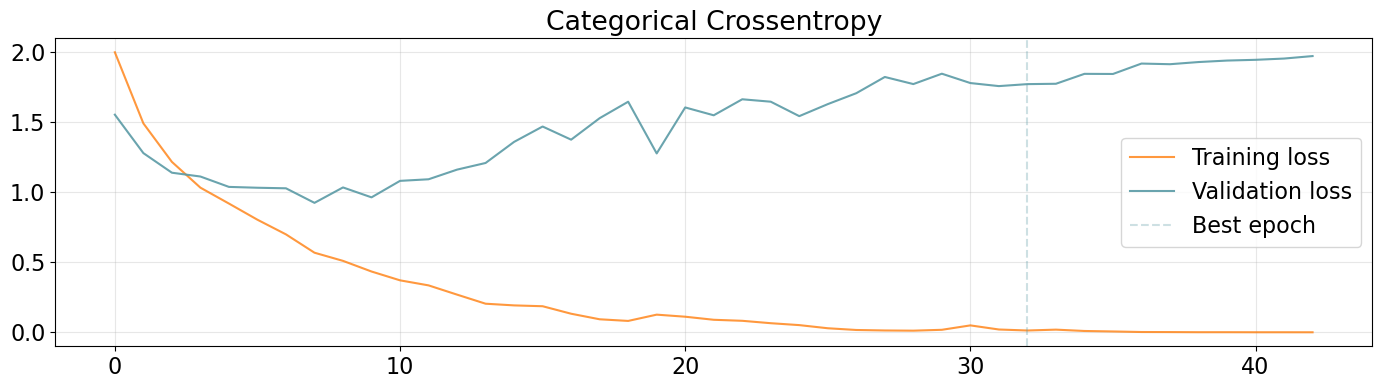

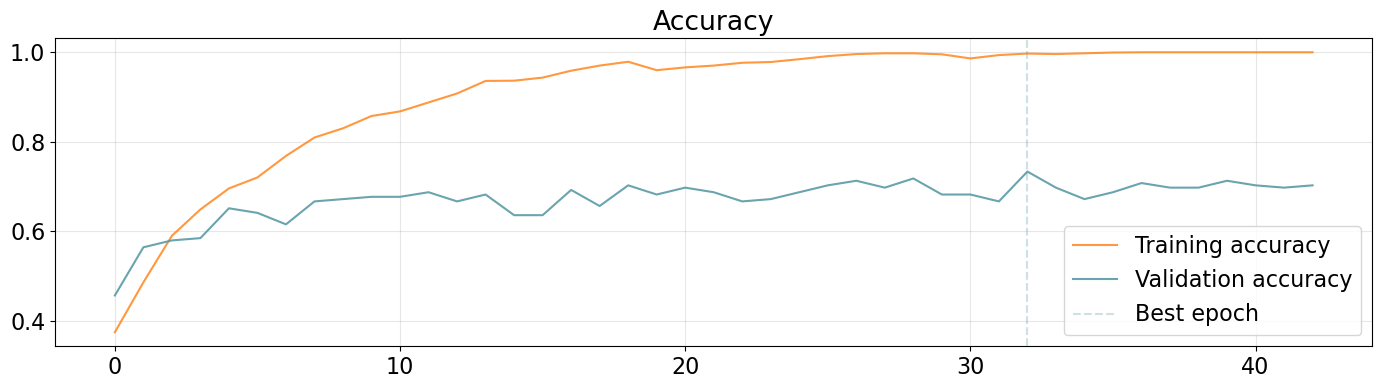

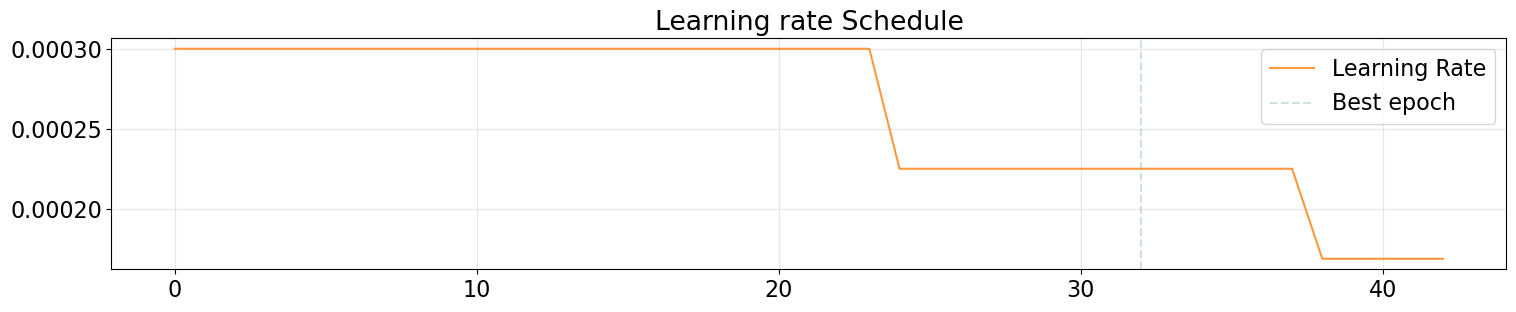

In [257]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.title('Learning rate Schedule')
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Bidirectional LSTM model evaluation

In [258]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 3s 45ms/step


(486, 12)

Accuracy: 0.6646
Precision: 0.611
Recall: 0.5192
F1: 0.5435


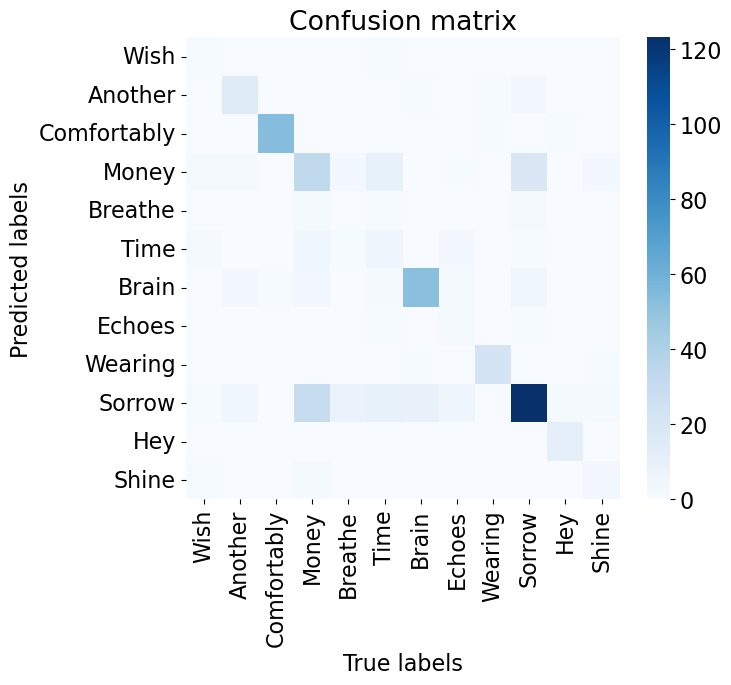

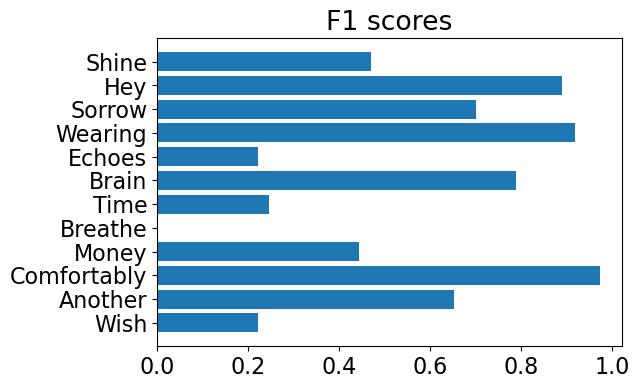

In [259]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(7,6))
plt.title('Confusion matrix')
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# horizontal bar plot of the f1 scores for each class
plt.figure(figsize=(6,4))
plt.barh(y=list(label_mapping.keys()), width=f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None))
plt.title('F1 scores')
plt.show()


#### 1D Convolutional Neural Network

In [260]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [261]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 36, 128)           2432      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d_6   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_28 (Dropout)        (None, 128)               0     

In [262]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
14/14 [==============================] - 1s 38ms/step - loss: 20.4735 - accuracy: 0.0841 - val_loss: 5.4518 - val_accuracy: 0.1128 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 11.4800 - accuracy: 0.1362 - val_loss: 5.5554 - val_accuracy: 0.0410 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 6.7544 - accuracy: 0.1516 - val_loss: 3.6442 - val_accuracy: 0.0667 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 0s 13ms/step - loss: 4.4656 - accuracy: 0.1659 - val_loss: 3.7367 - val_accuracy: 0.1846 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 0s 13ms/step - loss: 3.6922 - accuracy: 0.2506 - val_loss: 2.8969 - val_accuracy: 0.2821 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 0s 13ms/step - loss: 2.9316 - accuracy: 0.3032 - val_loss: 2.2911 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 0s 13ms/step - 

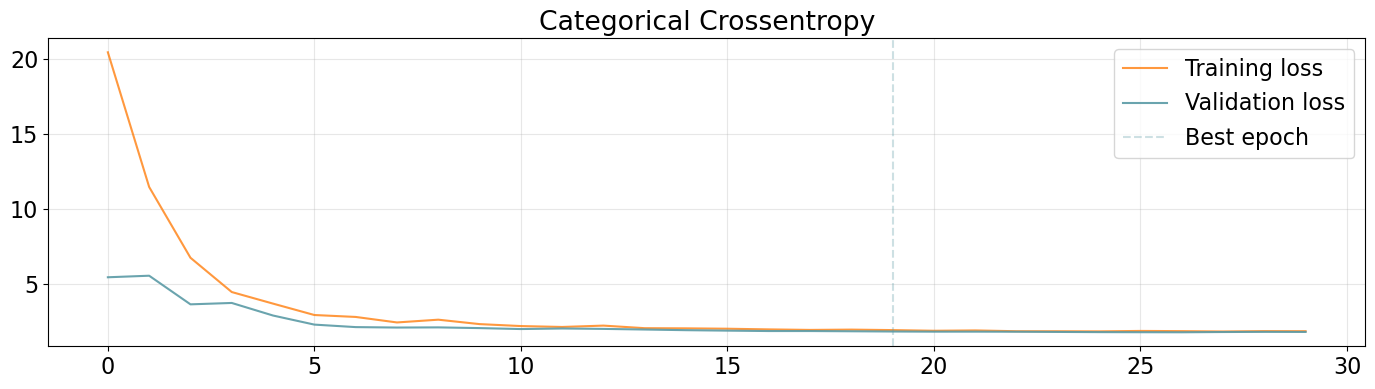

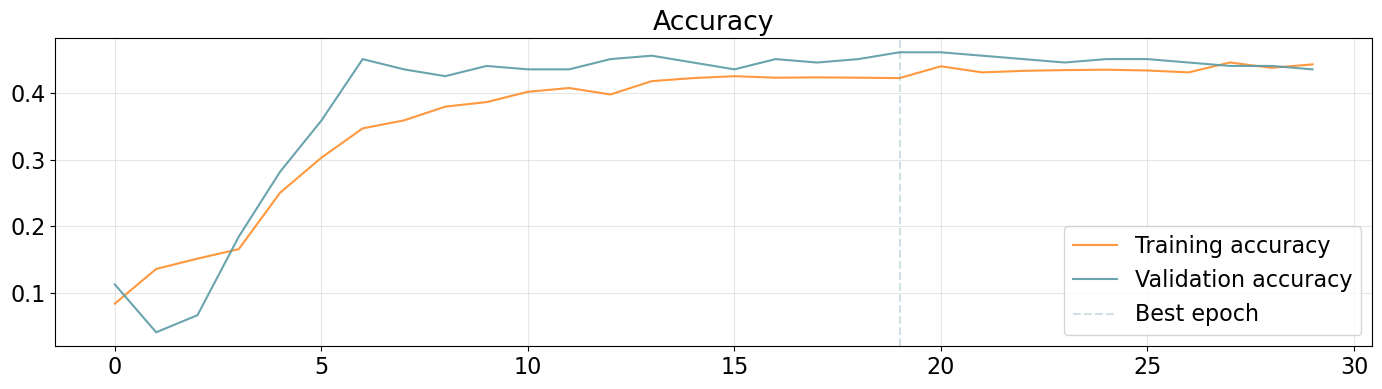

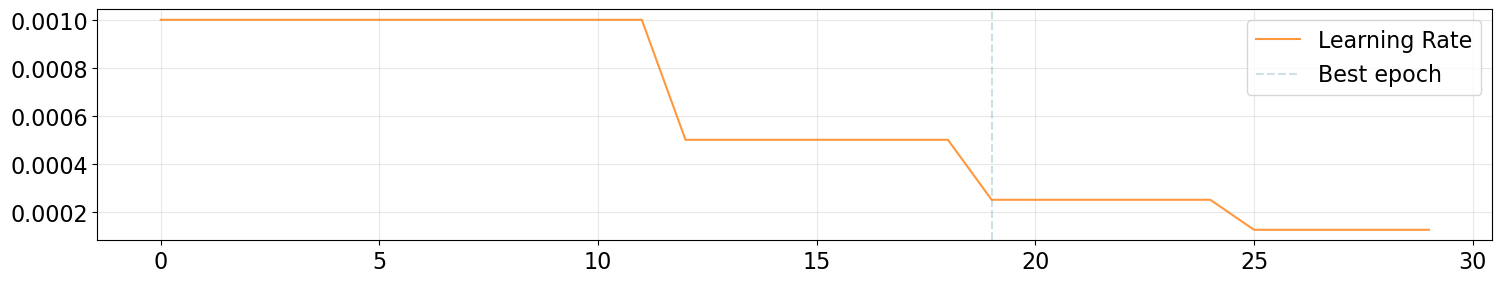

In [263]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.title('Learning rate Schedule')
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Convolution in 1D model evaluation

In [264]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)

16/16 [==============================] - 0s 3ms/step


Accuracy: 0.4424
Precision: 0.4063
Recall: 0.2738
F1: 0.2668


d:\Programs\Anaconda\envs\anndl\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


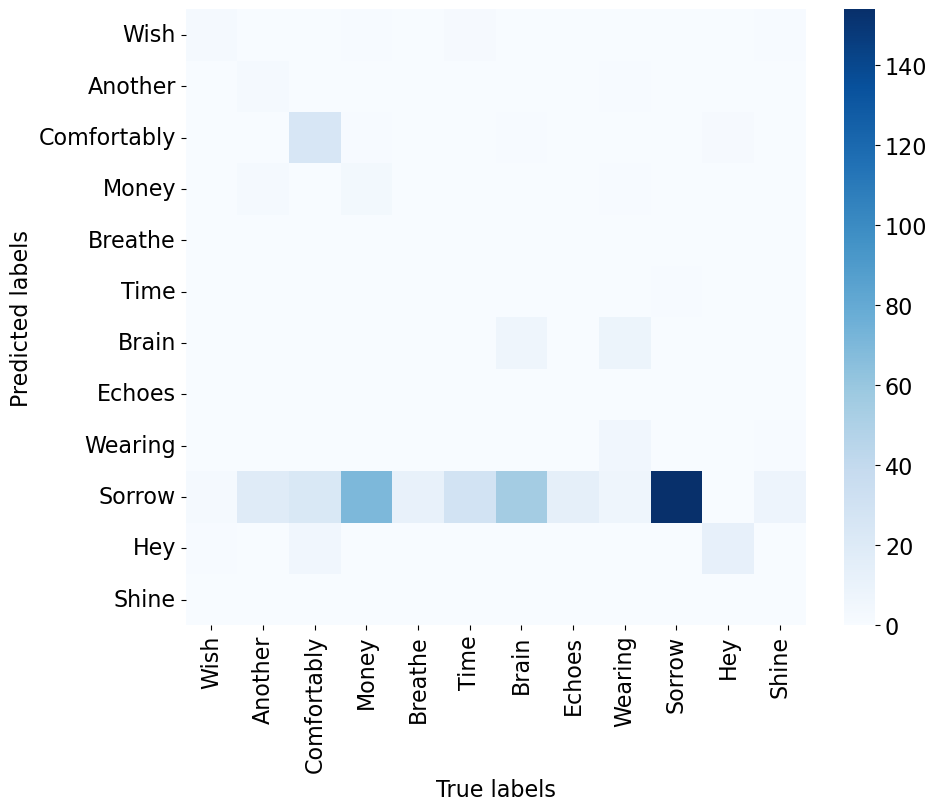

In [265]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(7,6))
plt.title('Confusion matrix')
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# horizontal bar plot of the f1 scores for each class
plt.figure(figsize=(6,4))
plt.barh(y=list(label_mapping.keys()), width=f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None))
plt.title('F1 scores')
plt.show()